# Optimal Transport Project: OT-GAN

Jingyi LI, Wendong LIANG

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
from time import time
from tqdm.notebook import tqdm
import datetime as dt
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
from torchvision.utils import make_grid 
plt.ion()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utils

## Dataset

In [ ]:
class Dataset():
    def __init__(self, dataset="MNIST", batch_size = 512):
        self.dataset = dataset
        self.batch_size = batch_size
        self.transformer=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        '''
        self.img_rows = dataloader.dataset[0][0].shape[0]
        self.img_cols = dataloader.dataset[0][0].shape[1]
        self.img_channels = dataloader.dataset[0][0].shape[2]
        self.img_shape = (self.img_rows, self.img_cols, self.img_channels)
        '''
    def __len__(self):
        return self.data_train.shape[0]


    def load(self):
        if self.dataset == 'CIFAR10':
            self.transformer = transforms.Compose([transforms.ToTensor(),
                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
            data_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=self.transformer)
            
            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 
                       'horse', 'ship', 'truck')
            
        elif self.dataset == 'MNIST':
            self.transformer = transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        
            data_train = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=self.transformer)
            self.classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

        elif self.dataset == 'FashionMNIST':
            transformer = transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        
            data_train = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                      download=True, transform=self.transformer)
            self.classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
        else:
            raise("unknown dataset")
        """    
        self.loader1 = torch.utils.data.DataLoader(data_train, 
                                      batch_size=self.batch_size,shuffle=True)
        self.loader2 = torch.utils.data.DataLoader(data_train, 
                                      batch_size=self.batch_size,shuffle=True)
        return self.loader1, self.loader2
        """
        return torch.utils.data.DataLoader(data_train, 
                                      batch_size=self.batch_size,shuffle=True)

In [ ]:
# GPU configuration
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

In [ ]:
# loader1, loader2= Dataset(dataset = 'FashionMNIST').load()

In [ ]:
# data_iter=iter(loader1)
# image,labels = data_iter.next()
# image.size()[1:]

## Plot

In [ ]:
def show(samples):
    plt.figure(figsize=(16, 8))
    m = make_grid(samples, nrow=8, scale_each = True, normalize = True, padding = 2)
    npimg = m.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

# Models

In [ ]:
class Reshape(nn.Module):
    def __init__(self, *args):
        nn.Module.__init__(self)
        self.args = args

    def forward(self, x):
        return x.view(*self.args)


class Generator(nn.Module):
    def __init__(self, input_size=100, hidden_dim=512, kernel_size=5, output_dim=1, img_x=28, img_y=28):
        #image_shape = [28,28,1]
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.padding = 2
        self.padding_out = int((img_x - 28)/2) #output_dim = 32 + 2*self.padding_out-self.kernel_size+1
        self.img_x = int(img_x)
        self.img_y = int(img_y)
        print("padding_out=",(img_x - 28)/2)

        #x_start = int(self.img_x / 4)
        #y_start = int(self.img_y / 4)
        #12544 and 7 should be defined by ourself
        #linear_output = int(2 * self.hidden_dim * x_start * y_start) #12544
        
        self.model = nn.Sequential(
            nn.Linear(input_size,16384), # [batch_size, 16384]
            nn.GLU(dim=1), # [batch_size, 8192]
            
            Reshape(-1,hidden_dim,4,4), # [batch_size, 512, 4, 4]
            nn.Upsample(scale_factor=2, mode="nearest"), # [batch_size, 512, 8, 8]
            nn.Conv2d(
                self.hidden_dim,
                self.hidden_dim,
                kernel_size=self.kernel_size,
                padding=self.padding,
                stride=1,
            ),   #[batch_size, 512, 8, 8]
        
            nn.GLU(dim=1),  # [batch_size, 256, 8, 8]
            nn.Upsample(scale_factor=2, mode="nearest"), # [batch_size, 256, 16, 16]

            nn.Conv2d(
                hidden_dim // 2,
                hidden_dim // 2,
                kernel_size=self.kernel_size,
                padding=self.padding,
                stride=1,
            ), # [batch_size, 256, 16, 16]
            nn.GLU(dim=1),  # [batch_size, 128, 16, 16]
            nn.Upsample(scale_factor=2, mode="nearest"), # [batch_size, 128, 32, 32]

            nn.Conv2d(
                hidden_dim // 4, #32
                hidden_dim // 4, #32
                kernel_size=self.kernel_size,
                padding=self.padding_out,
                stride=1,
            ),  # [batch_size, 128, 28, 28]
            nn.GLU(dim=1),# [batch_size, 64, 28, 28]
            nn.Conv2d(
                hidden_dim // 8, #1
                output_dim, #1
                kernel_size=self.kernel_size,
                padding=self.padding,
                stride=1,
            ),
            nn.Tanh(), # [batch_size, 1, 28, 28]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


In [ ]:
class CReLU(nn.Module):
    def __init__(self):
        super(CReLU, self).__init__()

    @staticmethod
    def forward(x: torch.Tensor) -> torch.Tensor:
        return torch.cat((F.relu(x), F.relu(-x)), 1)

class L2Normalize(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)

    @staticmethod
    def forward(x):
        return F.normalize(x, dim=1, p=2)

class Critic(nn.Module):
    def __init__(self, input_size=1, hidden_dim=128, kernel_size=5, img_x=28, img_y=28)->None:
        nn.Module.__init__(self)
        self.hidden_dim = hidden_dim  # 128
        self.input_size = input_size  # 1
        self.kernel_size = kernel_size  # 5
        self.padding = 2
        self.padding_in = 2
        
        # input = [batch_size,1,28,28]
        self.model = nn.Sequential(
            nn.Conv2d(
                self.input_size, #1
                self.hidden_dim, #128
                kernel_size=self.kernel_size,
                padding=self.padding_in,
                stride=1,bias=False
            ), # [batch_size,128,32,32]
            CReLU(), # [batch_size,256,32,32]

            nn.Conv2d(
                2 * self.hidden_dim,
                2 * self.hidden_dim,
                kernel_size=self.kernel_size,
                padding=self.padding,
                stride=2,bias=False
            ), # [batch_size,256,16,16]
            CReLU(), # [batch_size,512,16,16]

            nn.Conv2d(
                4 * self.hidden_dim,
                4 * self.hidden_dim,
                kernel_size=self.kernel_size,
                padding=self.padding,
                stride=2,bias=False
            ), # [batch_size,512,8,8]
            CReLU(),# [batch_size,1024,8,8]

            nn.Conv2d(
                8 * self.hidden_dim,
                8 * self.hidden_dim,
                kernel_size=self.kernel_size,
                padding=self.padding,
                stride=2,bias=False
            ), # [batch_size,1024,4,4]
            CReLU(),# [batch_size,2048,4,4]
            Reshape(-1, 32768), #output_dim = 32768 
            L2Normalize(),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)
        #return torch.flatten(self.model(x),start_dim=1)


In [ ]:
class GAN(nn.Module):
    
    def __init__(self, gen_params, critic_params, dataset="MNIST", reg=500):
        super(GAN, self).__init__()
        self.dataloader = Dataset(dataset).load()
        # self.loader1, self.loader2 = self.dataloader
        # data_iter = iter(self.loader1)

        data_iter =iter(self.dataloader)
        image,labels = data_iter.next()
        img_shape = image.size()[1:] # [1,28,28]




        self.latent_dim = gen_params[0]
        self.hidden_dim = gen_params[1]
        self.kernel_size = gen_params[2]
        self.reg = reg
        self.critic_latent_dim = critic_params[0]

        gen_params_input = (self.latent_dim, self.hidden_dim, self.kernel_size, img_shape[0], img_shape[1], img_shape[2])
        critic_params_input = (img_shape[0], self.critic_latent_dim, kernel_size, img_shape[1], img_shape[2])


        self.generator = Generator(*gen_params_input).to(device)
        self.critic = Critic(*critic_params_input).to(device)
        self.update = 3

    def sample_data(self, n_sample=100):
        z_random = np.random.randn(n_sample, self.latent_dim)
        z_random = torch.FloatTensor(z_random).to(device)
        samples = self.generator(z_random)
        samples = samples.detach().cpu()
        return samples

    def sample_z(self, n_samples=1):
        """
        Uniform sampling in (-1,1), since torch.rand samples in [0,1).
        """
        return torch.rand(n_samples, self.latent_dim) * 2 - 1 
        

    def sinkhorn(self, a, b, C, reg=0.001, max_iters=100):
    
        K = torch.exp(-C/reg)
        u = torch.ones_like(a).to(device)
        v = torch.ones_like(b).to(device)
        for i in range(max_iters):
            u = a / torch.matmul(K,v)
            v = b / torch.matmul(K.T,u)
        return torch.matmul(torch.diag_embed(u), torch.matmul(K, torch.diag_embed(v)))






    def sinkhorn(self, a, b, C, reg=500, max_iters=100, delta = 1e-4, eps=1e-8):
        K = torch.exp(-C/reg)
        u = torch.ones_like(a).to(device)
        v = torch.ones_like(b).to(device)
        err = 1
        i = 0
        with torch.no_grad():
          while (i<max_iters and err>delta):
                u = a / (torch.matmul(K,v)+eps)
                v = b / (torch.matmul(K.T,u)+eps)
                err = np.sum(torch.abs(u * torch.matmul(K,v) - a).detach().cpu().numpy())
                i += 1
        return torch.matmul(torch.diag_embed(u), torch.matmul(K, torch.diag_embed(v)))

    def sinkhorn(self, a, b, C, max_iter=100, delta=1e-8, reg=100, eps=1e-8):
        """
        Computes the OT plan using the Sinkhorn algorithm.
        """
        # only need to initialize v or u
        v = torch.ones(b.shape)
        # we could normalize C (no noticeable changes when tested)
        # C = C / C.max()
        K = torch.exp(-C / reg) 

        # an older version, where we always do max_iter iterations. On the other
        #  hand, it is better if we always do max_iter iterations.
        # with torch.no_grad(): # Freeze parameters
        #     for _ in range(max_iter):
        #         u = a / (K @ v + eps)
        #         v = b / (K.T @ u + eps)

        with torch.no_grad(): # Freeze parameters
            it = 0
            err = delta + 1
            while (it<max_iter and err>delta):
                u = a / (K @ v + eps)
                v = b / (K.T @ u + eps)
                err = np.sum(np.abs((u * K @ v - a).detach().cpu().numpy()))
                it += 1
        return torch.diag(u) @ K @ torch.diag(v)
    def sinkhorn(self, a, b, C, reg=500, max_iters=100, delta = 1e-4, eps=1e-8):
        K = torch.exp(-C/reg)
        u = torch.ones_like(a).to(device)
        v = torch.ones_like(b).to(device)
        err = 1
        i = 0
        with torch.no_grad():
          while (i<max_iters and err>delta):
                u = a / (torch.matmul(K,v)+eps)
                v = b / (torch.matmul(K.T,u)+eps)
                err = np.sum(torch.abs(u * torch.matmul(K,v) - a).detach().cpu().numpy())
                i += 1
        return torch.matmul(torch.diag_embed(u), torch.matmul(K, torch.diag_embed(v)))

    def cost(self, batch_1, batch_2):
        #norm_1 = torch.norm(batch_1, p=2, dim=1).item()
        #norm_2 = torch.norm(batch_2, p=2, dim=1).item()
        #return 1 - torch.matmul(batch_1, batch_2.t()) / (norm_1 * norm_2)
        # norm_1 = torch.norm(batch_1, p=2, dim=1).reshape(-1,1)
        # norm_2 = torch.norm(batch_2, p=2, dim=1).reshape(-1,1)
        # return - torch.matmul(batch_1, batch_2.transpose(0,1)) / (torch.matmul(norm_1, norm_2.transpose(0,1))) + 1
        return 1 - torch.matmul(batch_1, batch_2.t())

    def train(self, epochs=25, print_iter=1):
        
        c_optimizer = optim.Adam(self.critic.parameters(), lr=3e-4, betas=(0.5, 0.999))
        g_optimizer = optim.Adam(self.generator.parameters(), lr=3e-4, betas=(0.5, 0.999))

        progress = []
        for epoch in tqdm(range(epochs)):
            
            t=time()
            
            i=0
            # for X_1, X_2 in tqdm(zip(self.loader1, self.loader2), total=len(self.loader1)):
                
            #     X_1=X_1[0]
            #     X_2=X_2[0]
            for (X,_) in tqdm(self.dataloader):
                # print(X_1.shape)
                # batch_size = X_1.shape[0]

                self.critic.zero_grad()
                self.generator.zero_grad()

                batch_size = X.shape[0] // 2
                X_1 = (X[:batch_size])
                X_2 = (X[batch_size:])
                X_1 = X_1.type(torch.FloatTensor).to(device) # [batch_size, 1, 28, 28]
                X_2 = X_2.type(torch.FloatTensor).to(device)
                #print("X_1.shape",X_1.shape)
                z1 = self.sample_z(batch_size).to(device)
                Y_1 = self.generator(z1).to(device) # [batch_size, 1, 28, 28]
                #print("Y_1.shape",Y_1.shape)
                z2 = self.sample_z(batch_size).to(device)
                Y_2 = self.generator(z2).to(device)
                
                critic_X_1 = self.critic(X_1) # [batch_size,32]
                #print("critic_X_1.shape",critic_X_1.shape)
                critic_X_2 = self.critic(X_2)
                critic_Y_1 = self.critic(Y_1)
                critic_Y_2 = self.critic(Y_2)

                # Computing all matrices of costs

               
                CX1X2 = self.cost(critic_X_1, critic_X_2)
                CX1Y1 = self.cost(critic_X_1, critic_Y_1)
                CX1Y2 = self.cost(critic_X_1, critic_Y_2)
                CX2Y1 = self.cost(critic_X_2, critic_Y_1)
                CX2Y2 = self.cost(critic_X_2, critic_Y_2)
                CY1Y2 = self.cost(critic_Y_1, critic_Y_2)

                # Computing optimal plans for all costs

                a = (torch.ones(batch_size) / batch_size).to(device)
                b = (torch.ones(batch_size) / batch_size).to(device)
                
                MX1X2 = self.sinkhorn(a, b, CX1X2, reg=self.reg).to(device)
                MX1Y1 = self.sinkhorn(a, b, CX1Y1, reg=self.reg).to(device)
                MX1Y2 = self.sinkhorn(a, b, CX1Y2, reg=self.reg).to(device)
                MX2Y1 = self.sinkhorn(a, b, CX2Y1, reg=self.reg).to(device)
                MX2Y2 = self.sinkhorn(a, b, CX2Y2, reg=self.reg).to(device)
                MY1Y2 = self.sinkhorn(a, b, CY1Y2, reg=self.reg).to(device)


                # Computing losses
                
                WX1X2 = torch.sum(MX1X2 * CX1X2)
                WX1Y1 = torch.sum(MX1Y1 * CX1Y1)
                WX1Y2 = torch.sum(MX1Y2 * CX1Y2)
                WX2Y1 = torch.sum(MX2Y1 * CX2Y1)
                WX2Y2 = torch.sum(MX2Y2 * CX2Y2)
                WY1Y2 = torch.sum(MY1Y2 * CY1Y2)
                
                
                loss = WX1Y1 + WX1Y2 + WX2Y1 + WX2Y2 - 2 * WX1X2 - 2 * WY1Y2
                
                if (i % self.update == 0): # Update critic
                    (-loss).backward()
                    c_optimizer.step()
                else:
                    loss.backward()
                    g_optimizer.step()
                i+=1
            progress.append(float(loss.detach().cpu().numpy()))


            if epoch % print_iter == 0:
                print("Epoch %s: Loss %s;  time (%s)" %
                    (epoch, sum(progress), time()-t))
                            
            if epoch % (print_iter*5) == 0:
                samples = self.sample_data(8)*256.
                show(samples)

            if (epoch % 10 == 0) or (epoch + 1 == epochs):
                path = './drive/MyDrive/otprojet/data/'
                torch.save(self.generator.state_dict(), 
                           path + 'OT_GAN_generator_exp1_' + 'epoch%d.pt' % 
                           (epoch))
                torch.save(self.critic.state_dict(), 
                           path + 'OT_GAN_critic_exp1_' + 'epoch%d.pt' % 
                           (epoch))
                print('Model saved ' +  'epoch%d.pt' % 
                           epoch)
        plt.plot(progress)
        plt.title("loss")
        return progress

# Results for MNIST non conditional

In [ ]:
dataset = "MNIST"

'''
img_shape = mnist_data[0].shape # [28,28,1]
img_size = img_shape[0] * img_shape[1] * img_shape[2]
'''
gen_latent_dim = 100
gen_hidden_dim = 512
kernel_size = 5
reg = 500 
critic_latent_dim = 128

gen_params = (gen_latent_dim, gen_hidden_dim, kernel_size)
critic_params = (critic_latent_dim, kernel_size)


gan = GAN(gen_params, critic_params, dataset, reg)




padding_out= 0.0


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0: Loss 0.004602491855621338;  time (149.89721488952637)


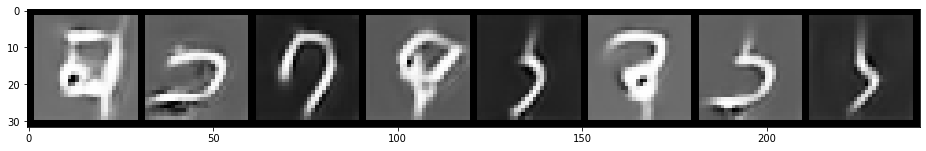

Model saved epoch0.pt


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1: Loss 0.005700051784515381;  time (150.0617880821228)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2: Loss 0.00741027295589447;  time (149.99421286582947)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3: Loss 0.007557244971394539;  time (149.91654801368713)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4: Loss 0.007698012515902519;  time (149.90523719787598)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 5: Loss 0.007836371660232544;  time (149.91034817695618)


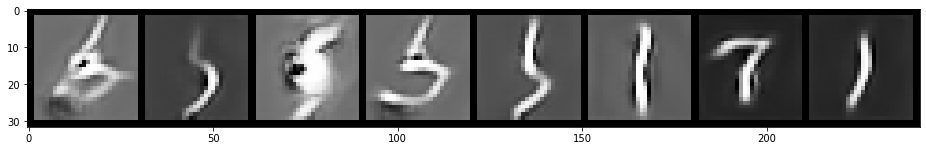

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 6: Loss 0.008051490411162376;  time (149.93375182151794)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 7: Loss 0.0097027737647295;  time (149.95597505569458)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 8: Loss 0.2183645088225603;  time (150.11363172531128)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 9: Loss 0.2192078549414873;  time (149.92078638076782)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 10: Loss 0.24812284298241138;  time (150.09248399734497)


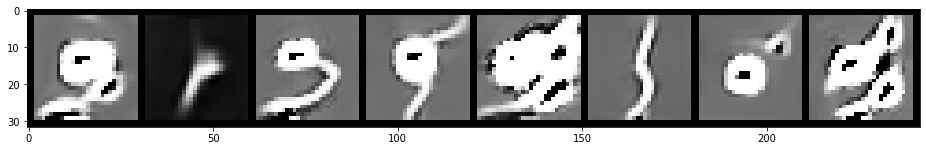

Model saved epoch10.pt


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 11: Loss 0.2629097867757082;  time (150.06312131881714)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 12: Loss 0.2634225506335497;  time (150.01806354522705)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 13: Loss 0.27488342113792896;  time (150.12012696266174)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 14: Loss 0.27482123859226704;  time (150.02752137184143)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 15: Loss 0.2744221892207861;  time (150.00264692306519)


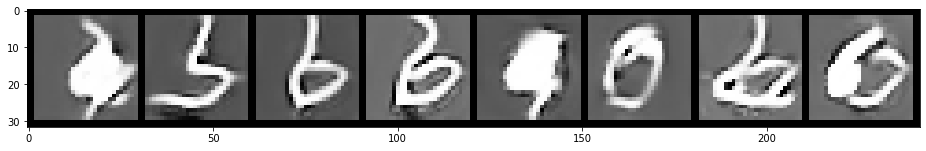

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 16: Loss 0.27444425970315933;  time (150.0683925151825)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 17: Loss 0.27416556514799595;  time (150.04677176475525)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 18: Loss 0.2739919237792492;  time (150.01191115379333)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 19: Loss 0.27401833795011044;  time (149.9646532535553)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 20: Loss 0.27402406372129917;  time (149.9402196407318)


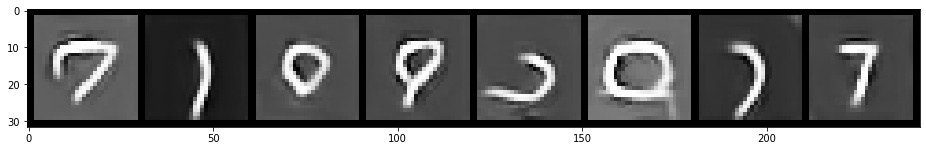

Model saved epoch20.pt


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 21: Loss 0.2745901308953762;  time (150.06190538406372)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 22: Loss 0.2742724008858204;  time (150.05445837974548)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 23: Loss 0.2753769848495722;  time (150.04521584510803)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 24: Loss 0.2746003773063421;  time (150.03820824623108)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 25: Loss 0.27418337389826775;  time (150.01517415046692)


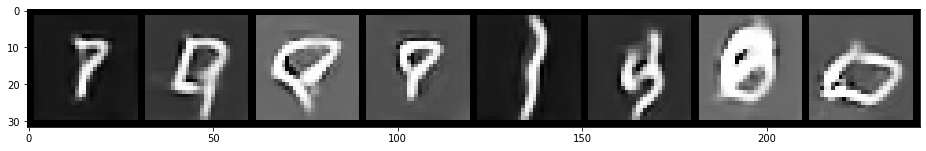

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 26: Loss 0.27434249967336655;  time (150.05807995796204)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 27: Loss 0.2744129095226526;  time (150.06184148788452)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 28: Loss 0.274606266990304;  time (150.02915954589844)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 29: Loss 0.2745643239468336;  time (150.00473809242249)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 30: Loss 0.27493711560964584;  time (150.049467086792)


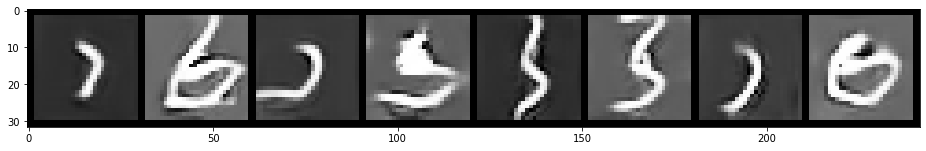

Model saved epoch30.pt


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 31: Loss 0.27526479586958885;  time (149.99228739738464)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 32: Loss 0.27588867768645287;  time (150.02378225326538)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 33: Loss 0.27637339010834694;  time (150.0682020187378)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 34: Loss 0.27743780612945557;  time (149.99190402030945)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 35: Loss 0.27738702297210693;  time (150.02382636070251)


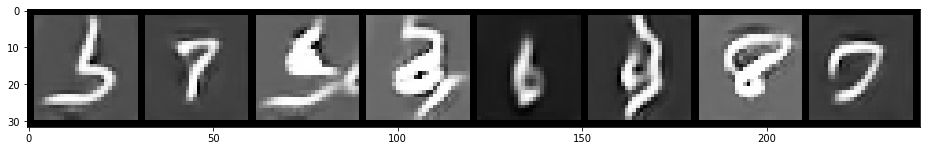

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 36: Loss 0.27734825015068054;  time (150.0495047569275)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 37: Loss 0.27620167285203934;  time (149.9421238899231)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 38: Loss 0.2763630300760269;  time (150.04642939567566)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 39: Loss 0.27375178784132004;  time (150.03340983390808)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 40: Loss 0.27029407024383545;  time (150.04387760162354)


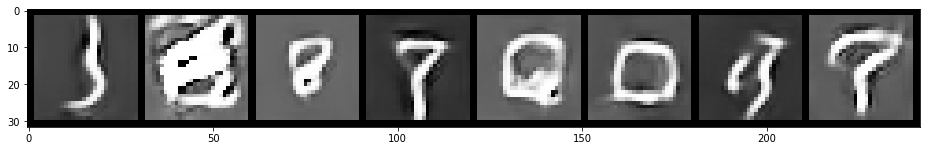

Model saved epoch40.pt


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 41: Loss 0.27064651995897293;  time (150.09270215034485)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 42: Loss 0.27064600959420204;  time (149.92576265335083)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 43: Loss 0.27077959943562746;  time (149.97443413734436)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 44: Loss 0.2710231812670827;  time (149.9798607826233)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 45: Loss 0.27129354048520327;  time (149.859228849411)


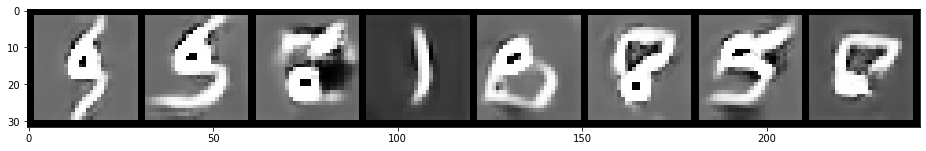

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 46: Loss 0.271104303188622;  time (149.94180631637573)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 47: Loss 0.27135613188147545;  time (149.9429166316986)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 48: Loss 0.27177887596189976;  time (149.86355090141296)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 49: Loss 0.27176381181925535;  time (149.96785306930542)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 50: Loss 0.27170011308044195;  time (149.96722602844238)


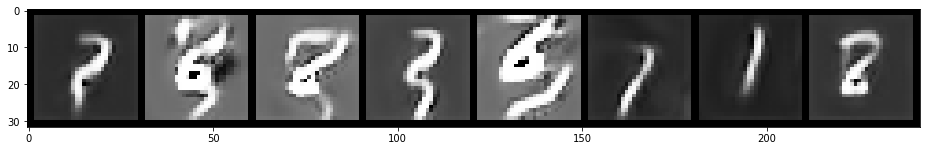

Model saved epoch50.pt


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 51: Loss 0.27169987838715315;  time (149.98837041854858)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 52: Loss 0.2718079639598727;  time (149.96070623397827)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 53: Loss 0.2717284895479679;  time (149.9312801361084)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 54: Loss 0.2716905875131488;  time (149.9723870754242)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 55: Loss 0.2716200863942504;  time (150.02214741706848)


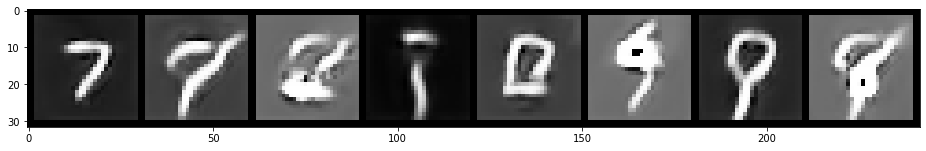

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 56: Loss 0.27157677710056305;  time (149.93072724342346)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 57: Loss 0.2717115692794323;  time (149.991525888443)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 58: Loss 0.27169619407504797;  time (150.05581545829773)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 59: Loss 0.27165989112108946;  time (150.0100634098053)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 60: Loss 0.2717355089262128;  time (149.9750316143036)


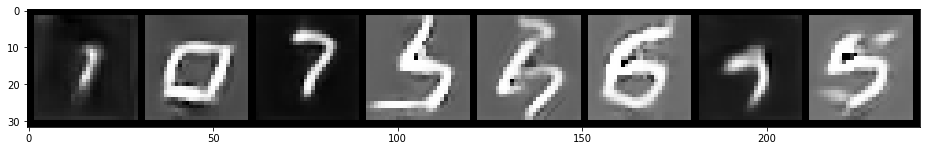

Model saved epoch60.pt


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 61: Loss 0.2715719575062394;  time (150.08989667892456)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 62: Loss 0.2715513566508889;  time (150.11511206626892)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 63: Loss 0.27154682017862797;  time (150.02838253974915)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 64: Loss 0.2716140579432249;  time (149.97859382629395)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 65: Loss 0.2715320475399494;  time (149.9053440093994)


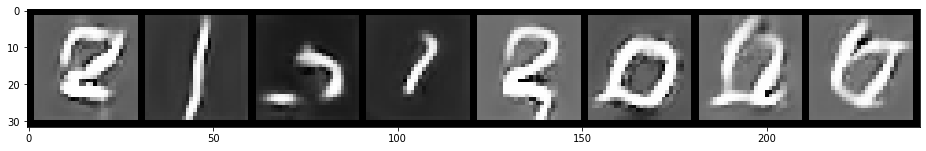

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 66: Loss 0.2717873053625226;  time (149.98535132408142)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 67: Loss 0.27228894364088774;  time (150.00812101364136)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 68: Loss 0.2722376650199294;  time (149.97858452796936)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 69: Loss 0.27226417046040297;  time (149.91880750656128)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 70: Loss 0.27215013559907675;  time (150.05963253974915)


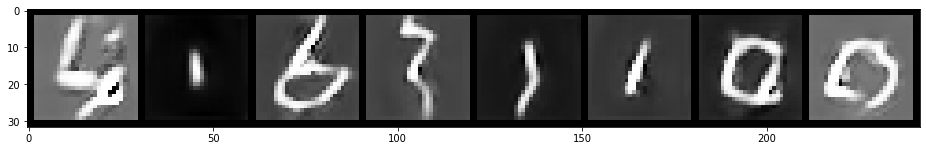

Model saved epoch70.pt


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 71: Loss 0.27298896107822657;  time (150.08222079277039)
Model saved epoch71.pt


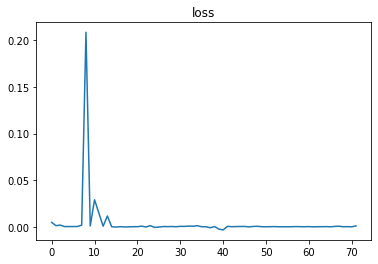

In [ ]:
progress = gan.train(26)
progress = gan.train(72)


# Results for MNIST non conditional, with another parameter on reg and $\beta_1$ in Adam optimizer

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0: Loss 142.2492482662201;  time (474.58982515335083)


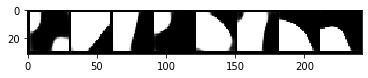

Model saved 2022-05-04_09h43_e0.pt


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1: Loss 343.498450756073;  time (488.604012966156)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2: Loss 468.1523003578186;  time (493.1405739784241)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3: Loss 470.29137897491455;  time (490.9676020145416)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4: Loss 471.130836725235;  time (490.53568840026855)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 5: Loss 471.4888188838959;  time (493.8102114200592)


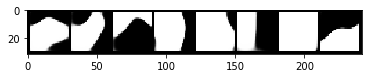

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 6: Loss 471.6078824996948;  time (491.1778042316437)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 7: Loss 471.6595973968506;  time (492.5356910228729)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 8: Loss 471.6821641921997;  time (492.90880966186523)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 9: Loss 471.6753764152527;  time (489.6469566822052)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 10: Loss 471.58492040634155;  time (474.49997329711914)


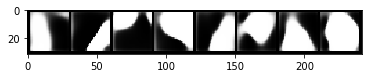

Model saved 2022-05-04_11h04_e10.pt


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 11: Loss 462.923659324646;  time (476.4796667098999)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 12: Loss 467.79825615882874;  time (479.81162190437317)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 13: Loss 470.568651676178;  time (478.07270884513855)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 14: Loss 459.3717737197876;  time (475.5386493206024)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 15: Loss 468.79938077926636;  time (477.32245230674744)


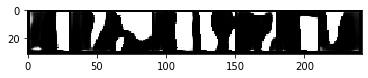

  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 16: Loss 469.4009382724762;  time (477.32714438438416)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 17: Loss 470.44228172302246;  time (473.51854634284973)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 18: Loss 467.9948043823242;  time (478.8952453136444)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 19: Loss 469.39750814437866;  time (480.28313088417053)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 20: Loss 470.5762846469879;  time (478.61806058883667)


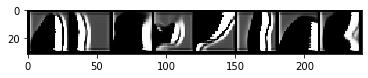

Model saved 2022-05-04_12h24_e20.pt


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 21: Loss 470.9517481327057;  time (477.90216064453125)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 22: Loss 471.12810945510864;  time (481.8020746707916)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 23: Loss 471.23605847358704;  time (477.0791425704956)


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 24: Loss 471.31162762641907;  time (479.7053906917572)
Model saved 2022-05-04_12h56_e24.pt


[3.9939064979553223,
 3.99350643157959,
 3.994225025177002,
 3.993971347808838,
 3.99418306350708,
 3.993696928024292,
 3.9939370155334473,
 3.9939680099487305,
 3.9940171241760254,
 3.9939427375793457,
 3.993983268737793,
 3.993535041809082,
 3.993938446044922,
 3.994396209716797,
 3.9940712451934814,
 3.9939754009246826,
 3.9943363666534424,
 3.9937551021575928,
 3.9941763877868652,
 3.994286298751831,
 3.993834972381592,
 3.994016647338867,
 3.9944629669189453,
 3.99430775642395,
 3.9940507411956787,
 3.993892192840576,
 3.9939968585968018,
 3.994157075881958,
 3.993990659713745,
 3.9941587448120117,
 3.994398355484009,
 3.9941697120666504,
 3.9944543838500977,
 3.993535041809082,
 3.9943432807922363,
 3.9941179752349854,
 3.9940738677978516,
 3.9942917823791504,
 3.9940195083618164,
 3.993614912033081,
 3.9943041801452637,
 3.9943158626556396,
 3.9939937591552734,
 3.994368314743042,
 3.994051456451416,
 3.994046449661255,
 3.9937071800231934,
 3.9940755367279053,
 3.99448871612548

In [ ]:
# with reg=100, beta1=0.5 in Adam optimizer
gan.train(25)

# Results for MNIST conditional

In [ ]:
dataset = "MNIST"

'''
img_shape = mnist_data[0].shape # [28,28,1]
img_size = img_shape[0] * img_shape[1] * img_shape[2]
'''
gen_latent_dim = 100
gen_hidden_dim = 512
kernel_size = 5
reg = 500 
critic_latent_dim = 128

gen_params = (gen_latent_dim, gen_hidden_dim, kernel_size)
critic_params = (critic_latent_dim, kernel_size)


gan = GAN(gen_params, critic_params, dataset, reg)



padding_out= 0.0


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 0: Loss 0.1264936625957489;  time (57.7771520614624)


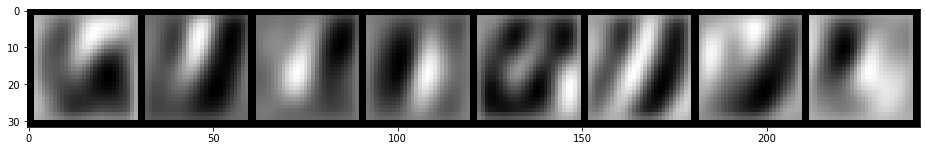

Model saved epoch0.pt


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1: Loss 0.5949834287166595;  time (56.472538471221924)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2: Loss 0.667807400226593;  time (57.20749306678772)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3: Loss 0.686024121940136;  time (57.020410776138306)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4: Loss 0.7602385655045509;  time (57.20756387710571)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5: Loss 1.2189852371811867;  time (57.25430130958557)


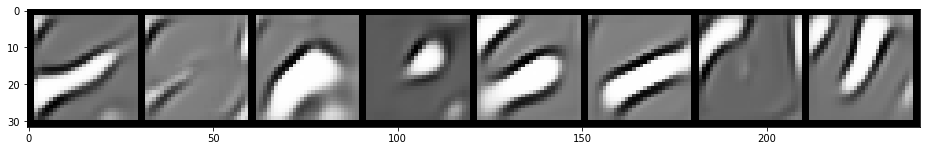

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6: Loss 1.2787945941090584;  time (57.16473031044006)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7: Loss 1.3212635889649391;  time (57.21041798591614)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8: Loss 1.3406203463673592;  time (57.073265075683594)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9: Loss 1.3611710295081139;  time (57.06793928146362)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10: Loss 1.3941077813506126;  time (57.15176820755005)


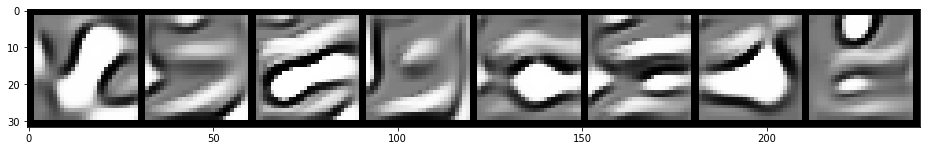

Model saved epoch10.pt


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11: Loss 1.8750041350722313;  time (57.29071927070618)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12: Loss 2.143909178674221;  time (57.214736223220825)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13: Loss 2.173761561512947;  time (57.12234616279602)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14: Loss 2.181124694645405;  time (57.15691685676575)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15: Loss 2.186531774699688;  time (57.04458451271057)


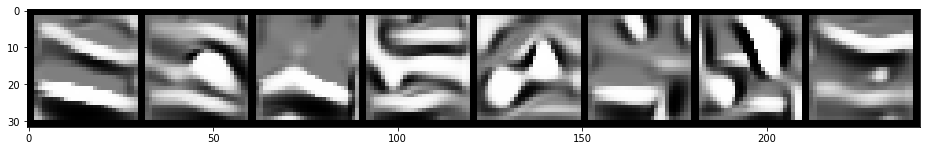

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16: Loss 2.1913088485598564;  time (57.18712615966797)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17: Loss 2.196663312613964;  time (57.15770649909973)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18: Loss 2.2019370049238205;  time (57.17586946487427)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19: Loss 2.207268476486206;  time (57.118311166763306)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20: Loss 2.2129983454942703;  time (57.10177755355835)


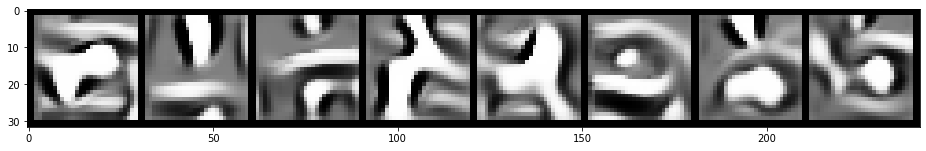

Model saved epoch20.pt


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 21: Loss 2.2196810469031334;  time (57.180673599243164)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 22: Loss 2.2272194251418114;  time (57.20120191574097)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 23: Loss 2.2397862896323204;  time (57.2388596534729)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 24: Loss 2.2929115518927574;  time (57.101526975631714)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 25: Loss 2.521392308175564;  time (56.97436809539795)


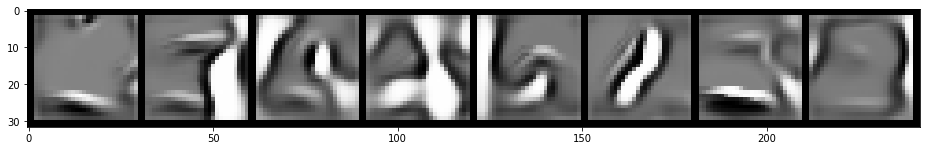

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 26: Loss 3.5879530534148216;  time (57.070860147476196)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 27: Loss 3.616676263511181;  time (57.15122056007385)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 28: Loss 3.660943739116192;  time (57.26276206970215)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 29: Loss 3.7430488392710686;  time (57.20166563987732)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 30: Loss 3.787336580455303;  time (57.1649534702301)


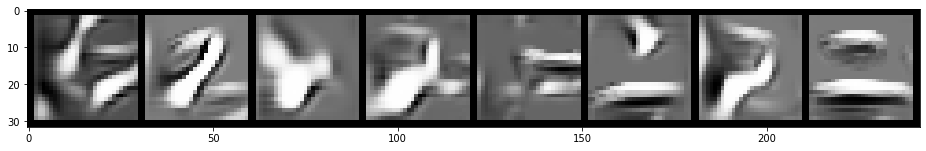

Model saved epoch30.pt


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 31: Loss 4.617932073771954;  time (57.1595733165741)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 32: Loss 4.681682460010052;  time (57.26114630699158)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 33: Loss 4.750952415168285;  time (57.19281220436096)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 34: Loss 4.796883575618267;  time (57.20768594741821)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 35: Loss 4.824726693332195;  time (57.31423807144165)


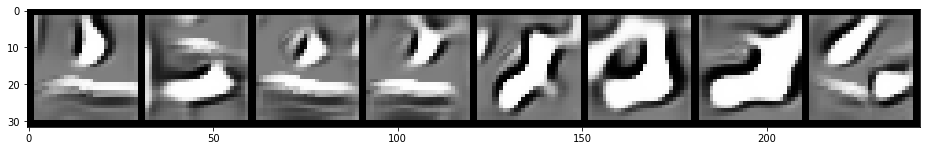

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 36: Loss 4.989275924861431;  time (57.287843465805054)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 37: Loss 5.286605589091778;  time (57.16043567657471)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 38: Loss 5.665474019944668;  time (57.1264386177063)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 39: Loss 5.758446715772152;  time (57.14592671394348)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 40: Loss 5.77290840819478;  time (57.22078728675842)


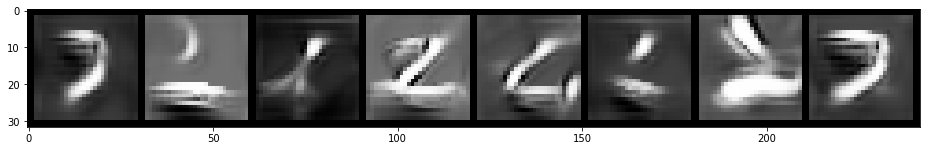

Model saved epoch40.pt


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 41: Loss 5.774233225733042;  time (57.11081838607788)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 42: Loss 5.775437269359827;  time (57.120898962020874)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 43: Loss 5.776228977367282;  time (56.93998956680298)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 44: Loss 5.776872161775827;  time (56.95052146911621)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 45: Loss 5.777522407472134;  time (56.92968392372131)


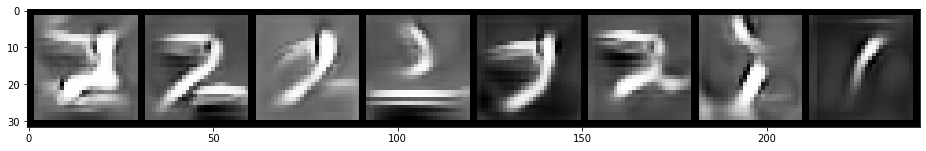

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 46: Loss 5.778114996850491;  time (57.03952670097351)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 47: Loss 5.778600204735994;  time (57.13954997062683)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 48: Loss 5.7790744584053755;  time (57.09324669837952)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 49: Loss 5.7793986070901155;  time (57.118590354919434)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 50: Loss 5.779817698523402;  time (57.0913143157959)


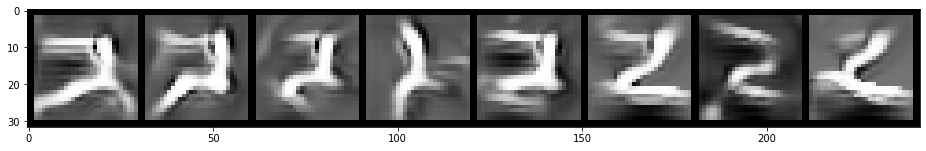

Model saved epoch50.pt


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 51: Loss 5.780198512598872;  time (57.02120780944824)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 52: Loss 5.780759133398533;  time (56.997971534729004)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 53: Loss 5.781436238437891;  time (57.025150537490845)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 54: Loss 5.781980190426111;  time (56.97037601470947)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 55: Loss 5.782385911792517;  time (56.99097919464111)


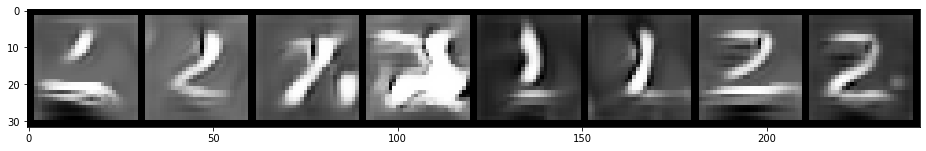

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 56: Loss 5.78279572352767;  time (56.977593660354614)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 57: Loss 5.78325904533267;  time (56.980687618255615)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 58: Loss 5.783683642745018;  time (57.023542404174805)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 59: Loss 5.78406011685729;  time (57.08629322052002)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 60: Loss 5.784457525238395;  time (57.03465938568115)


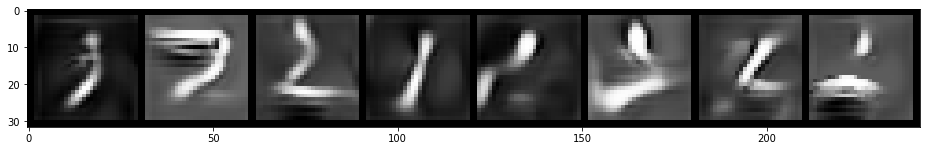

Model saved epoch60.pt


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 61: Loss 5.784822665154934;  time (57.06535243988037)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 62: Loss 5.7851542215794325;  time (57.15308666229248)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 63: Loss 5.78549381904304;  time (56.86712288856506)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 64: Loss 5.785863891243935;  time (56.894065141677856)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 65: Loss 5.786376170814037;  time (57.05802011489868)


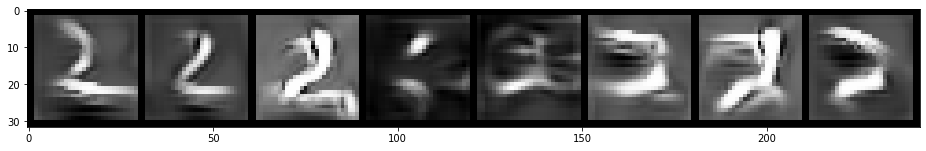

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 66: Loss 5.786867167800665;  time (57.00477910041809)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 67: Loss 5.7872660253196955;  time (56.93965268135071)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 68: Loss 5.787485444918275;  time (57.01798915863037)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 69: Loss 5.7879353035241365;  time (57.023720502853394)


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 70: Loss 5.788168864324689;  time (56.991323471069336)


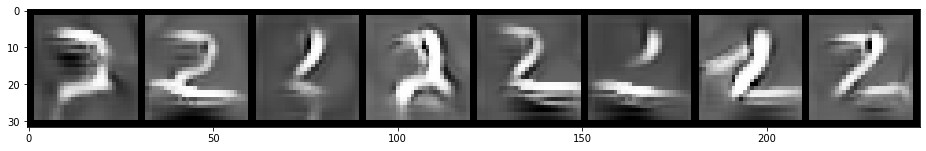

Model saved epoch70.pt


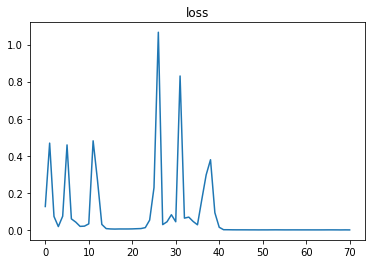

In [ ]:
progress = gan.train(71)

# Results for CIFAR10

In [ ]:
dataset = "CIFAR10"

'''
img_shape = mnist_data[0].shape # [28,28,1]
img_size = img_shape[0] * img_shape[1] * img_shape[2]
'''
gen_latent_dim = 100
gen_hidden_dim = 512
kernel_size = 5
reg = 500 
critic_latent_dim = 128

gen_params = (gen_latent_dim, gen_hidden_dim, kernel_size)
critic_params = (critic_latent_dim, kernel_size)


gan = GAN(gen_params, critic_params, dataset, reg)




Files already downloaded and verified
padding_out= 2.0


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 0: Loss 0.06388384103775024;  time (511.0453736782074)


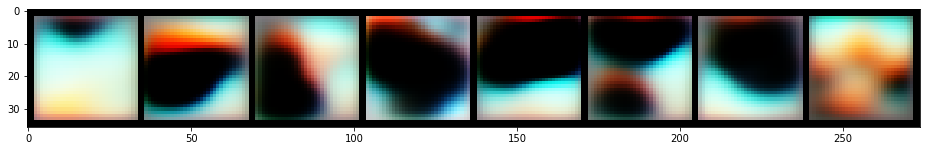

Model saved epoch0.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1: Loss 0.19120442867279053;  time (520.9530253410339)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2: Loss 0.19423453882336617;  time (520.1509835720062)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3: Loss 0.20148258283734322;  time (520.9949085712433)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 4: Loss 0.2053932435810566;  time (521.6063401699066)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 5: Loss 0.35471658781170845;  time (521.5674347877502)


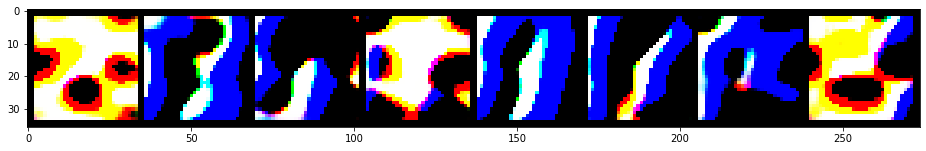

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 6: Loss 1.1271552331745625;  time (522.5858442783356)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 7: Loss 1.1278907544910908;  time (521.9022407531738)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 8: Loss 1.1642795987427235;  time (522.1527433395386)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 9: Loss 1.2080587334930897;  time (522.602796792984)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 10: Loss 1.220867607742548;  time (521.7428333759308)


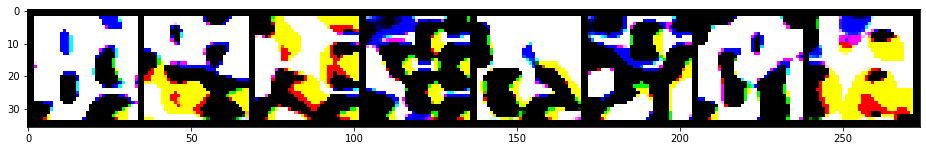

Model saved epoch10.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 11: Loss 1.6033463515341282;  time (522.9249038696289)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 12: Loss 1.6496616937220097;  time (522.5936455726624)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 13: Loss 1.654399836435914;  time (521.2532689571381)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 14: Loss 1.6633333498612046;  time (519.5796766281128)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 15: Loss 1.687849418260157;  time (520.5490274429321)


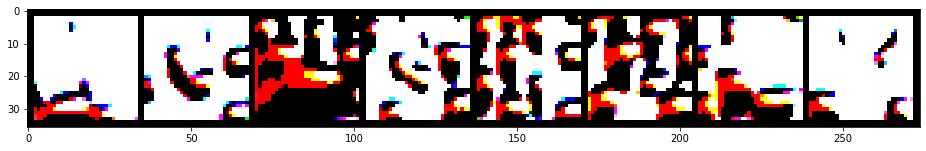

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 16: Loss 1.6977244773879647;  time (522.3733170032501)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 17: Loss 1.7626312533393502;  time (521.3397033214569)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 18: Loss 1.7732993522658944;  time (522.0132749080658)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 19: Loss 1.781352655030787;  time (521.6397843360901)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 20: Loss 4.244547502137721;  time (522.2405307292938)


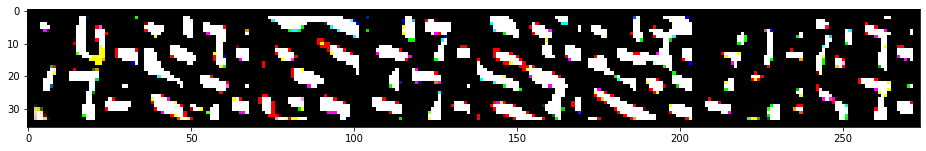

Model saved epoch20.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 21: Loss 4.920420424081385;  time (521.615002155304)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 22: Loss 5.071423948742449;  time (521.4428906440735)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 23: Loss 5.214286864735186;  time (520.8582172393799)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 24: Loss 5.219407559372485;  time (521.8684463500977)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 25: Loss 5.22567677590996;  time (521.5521309375763)


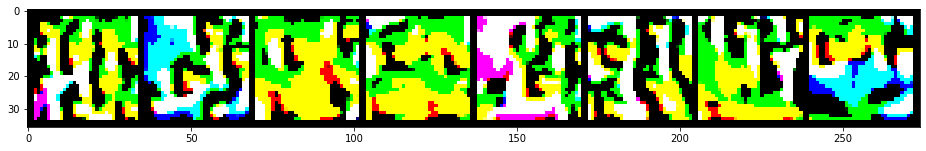

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 26: Loss 5.236630202271044;  time (522.069943189621)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 27: Loss 5.2388995895162225;  time (521.7587976455688)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 28: Loss 5.24152606818825;  time (522.2372555732727)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 29: Loss 5.246204794384539;  time (522.1946334838867)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 30: Loss 5.415811480022967;  time (522.3579668998718)


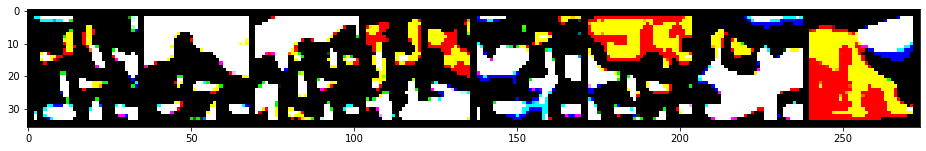

Model saved epoch30.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 31: Loss 5.419157647527754;  time (521.6631870269775)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 32: Loss 5.592139624990523;  time (521.2833385467529)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 33: Loss 5.744971045292914;  time (521.6805489063263)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 34: Loss 5.7559841657057405;  time (521.8668704032898)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 35: Loss 6.3577605271711946;  time (522.3735609054565)


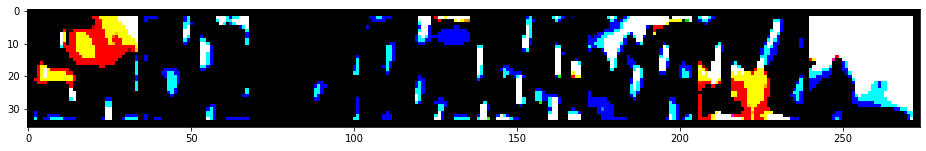

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 36: Loss 8.603574850596488;  time (520.4480848312378)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 37: Loss 8.609779573045671;  time (520.0691494941711)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 38: Loss 8.617632280103862;  time (520.7313356399536)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 39: Loss 8.636568042449653;  time (520.1479215621948)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 40: Loss 12.315929385833442;  time (521.2956132888794)


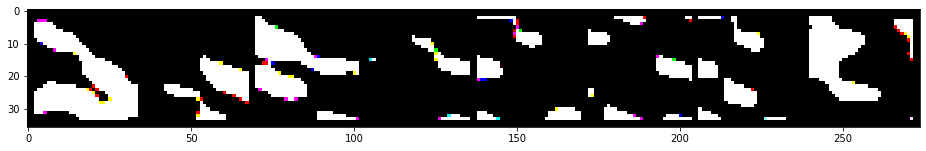

Model saved epoch40.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 41: Loss 16.228643628768623;  time (520.6771566867828)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 42: Loss 20.14410230796784;  time (519.863762140274)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 43: Loss 23.84251973312348;  time (520.3509974479675)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 44: Loss 27.754957648925483;  time (521.0882172584534)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 45: Loss 31.679937812499702;  time (521.3429374694824)


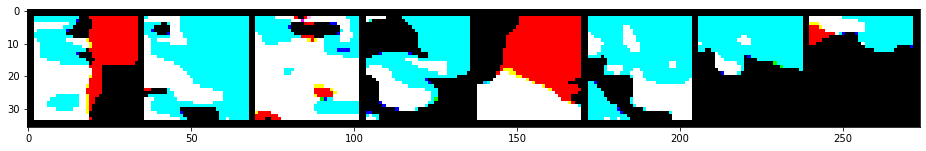

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 46: Loss 35.60865184944123;  time (520.4046125411987)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 47: Loss 39.52802893798798;  time (520.3818161487579)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 48: Loss 43.46817824523896;  time (520.2444779872894)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 49: Loss 47.4160594670102;  time (519.7593929767609)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 50: Loss 51.365656348876655;  time (519.9250311851501)


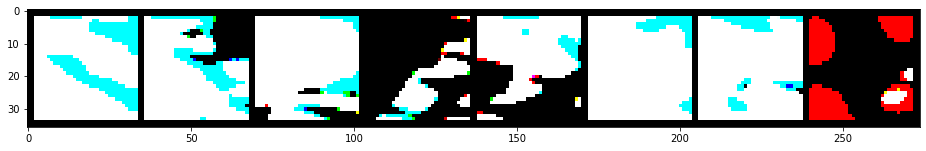

Model saved epoch50.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 51: Loss 55.3193433014676;  time (520.6400768756866)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 52: Loss 59.27910706680268;  time (519.3072724342346)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 53: Loss 61.27222678344697;  time (519.7194638252258)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 54: Loss 65.19442174118012;  time (520.4082274436951)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 55: Loss 69.0964441029355;  time (520.4662036895752)


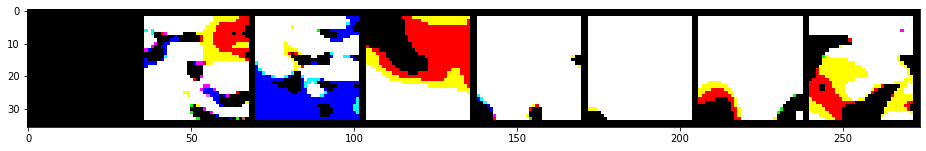

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 56: Loss 73.04830286186188;  time (520.1748313903809)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 57: Loss 76.9946396080777;  time (520.9343712329865)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 58: Loss 80.96093127410859;  time (520.4071173667908)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 59: Loss 84.79480406921357;  time (520.9410061836243)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 60: Loss 88.76135823410004;  time (521.0471713542938)


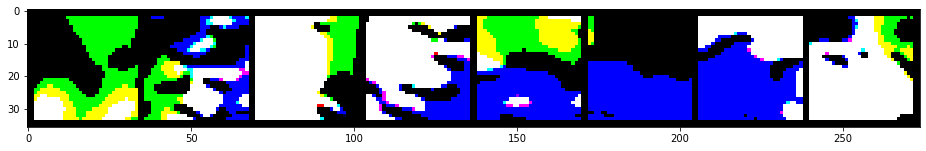

Model saved epoch60.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 61: Loss 92.71615764778107;  time (521.1950039863586)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 62: Loss 96.69271037261933;  time (521.182154417038)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 63: Loss 100.66897151153535;  time (521.7441568374634)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 64: Loss 104.64582869689912;  time (521.0679161548615)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 65: Loss 108.6072797505185;  time (520.0567214488983)


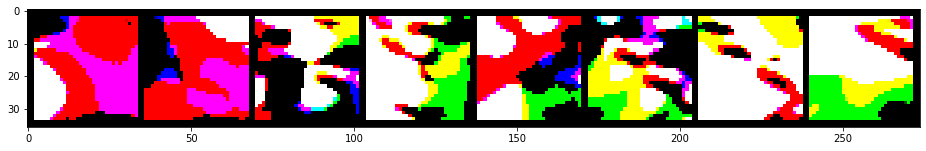

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 66: Loss 112.57767245452851;  time (521.0103387832642)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 67: Loss 116.54026982467622;  time (521.0200228691101)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 68: Loss 120.51490685623139;  time (519.900351524353)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 69: Loss 124.49286601226777;  time (519.7111985683441)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 70: Loss 128.47248170059174;  time (520.6147048473358)


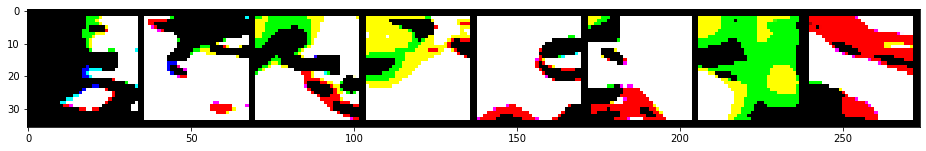

Model saved epoch70.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 71: Loss 132.44204160850495;  time (520.2682039737701)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 72: Loss 136.4149059979245;  time (520.5406985282898)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 73: Loss 140.3916330067441;  time (520.373594045639)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 74: Loss 144.37166497390717;  time (521.4249179363251)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 75: Loss 148.3433921067044;  time (520.5876758098602)


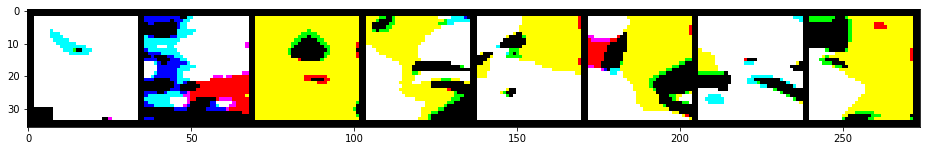

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 76: Loss 152.32021901290864;  time (520.4589836597443)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 77: Loss 156.29119226615876;  time (520.8452496528625)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 78: Loss 160.2677144734189;  time (520.2242476940155)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 79: Loss 164.25196430366486;  time (520.80588555336)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 80: Loss 168.21926424186677;  time (520.0542466640472)


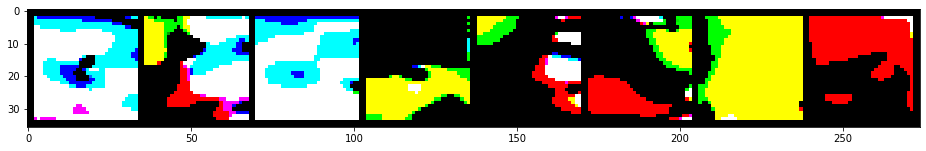

Model saved epoch80.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 81: Loss 172.20396921318024;  time (521.2097220420837)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 82: Loss 176.18553635757416;  time (521.4269609451294)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 83: Loss 180.17127558868378;  time (520.9907703399658)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 84: Loss 184.1562652317807;  time (521.2305378913879)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 85: Loss 188.14367577712983;  time (521.2938215732574)


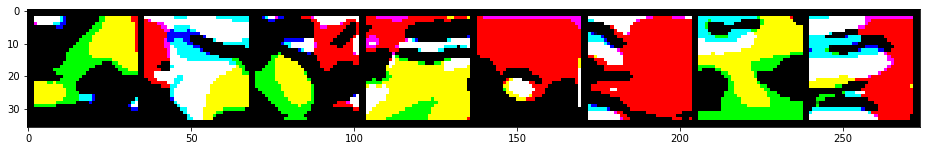

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 86: Loss 192.13106939475983;  time (521.2714178562164)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 87: Loss 196.11594316642731;  time (521.0450351238251)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 88: Loss 200.10103461425751;  time (521.3982107639313)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 89: Loss 204.08653971832246;  time (520.6624224185944)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 90: Loss 208.0758859841153;  time (519.9340023994446)


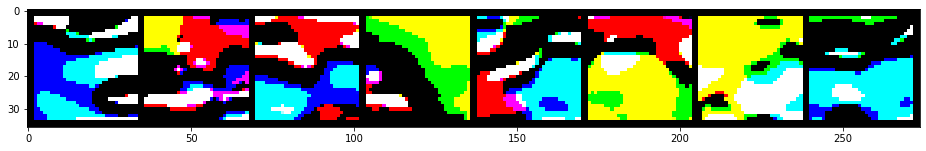

Model saved epoch90.pt


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 91: Loss 212.04853746574372;  time (521.0346117019653)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 92: Loss 216.03849622886628;  time (521.3083941936493)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 93: Loss 220.02611801307648;  time (521.0257604122162)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 94: Loss 224.01738378684968;  time (520.4741561412811)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 95: Loss 228.00697514694184;  time (519.8217551708221)


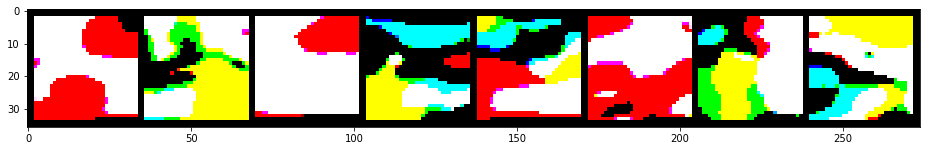

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 96: Loss 230.8946230141446;  time (519.8117542266846)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 97: Loss 234.76598689239472;  time (519.827205657959)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 98: Loss 238.70925614517182;  time (520.5571894645691)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 99: Loss 242.65757367294282;  time (520.2493119239807)


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch 100: Loss 246.6176671711728;  time (520.5484240055084)


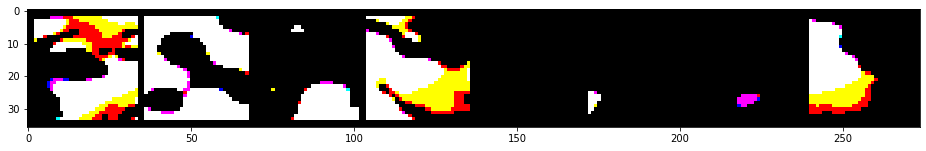

Model saved epoch100.pt


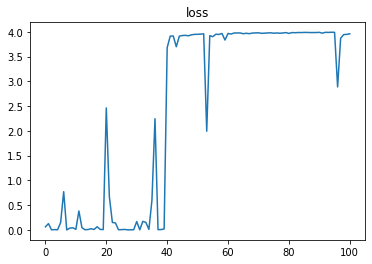

In [ ]:
progress = gan.train(101)


In [ ]:
def show(samples):
    plt.figure(figsize=(16, 16))
    m = make_grid(samples, nrow=8, scale_each = True, normalize = True, padding = 2)
    npimg = m.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()


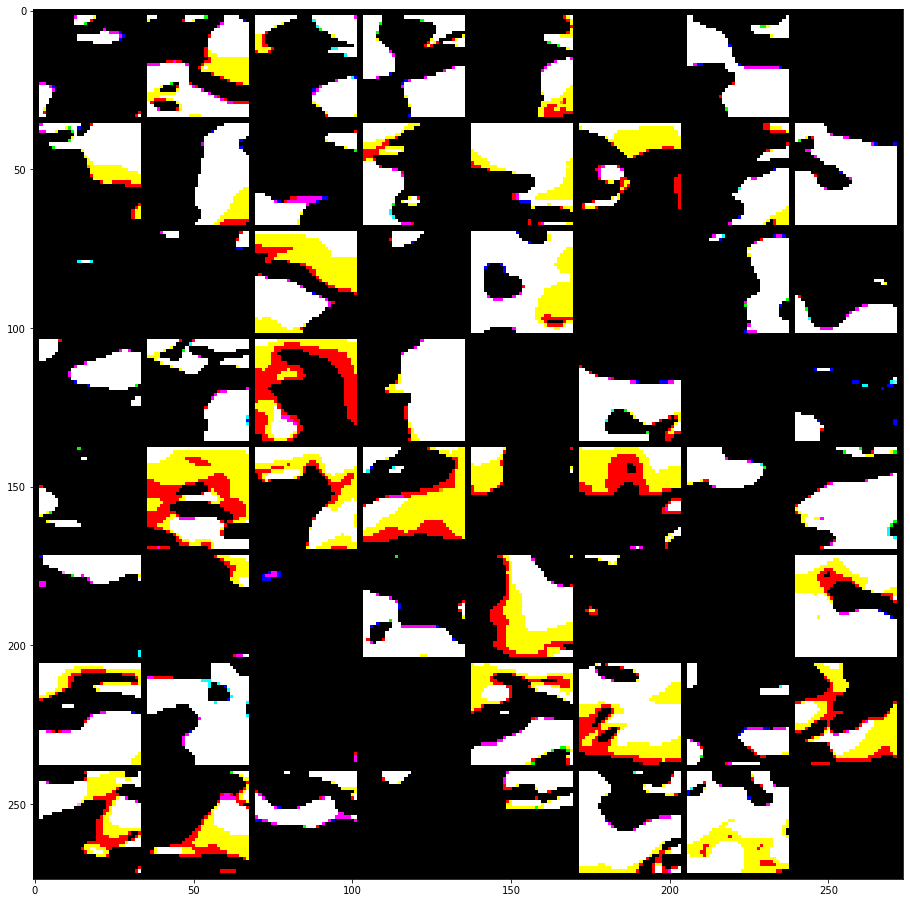

In [ ]:
samples = gan.sample_data(64)*256.
show(samples)